In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def initialize_parameters(vocab_size, hidden_layer_size):

    parameters = {}
    parameters["Whh"] = np.random.randn(
        hidden_layer_size, hidden_layer_size) * 0.01
    parameters["Wxh"] = np.random.randn(hidden_layer_size, vocab_size) * 0.01
    parameters["b"] = np.zeros((hidden_layer_size, 1))
    parameters["Why"] = np.random.randn(vocab_size, hidden_layer_size) * 0.01
    parameters["c"] = np.zeros((vocab_size, 1))

    return parameters


def initialize_adam(parameters):

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    v = {}
    s = {}

    for param_name in parameters_names:
        v["d" + param_name] = np.zeros_like(parameters[param_name])
        s["d" + param_name] = np.zeros_like(parameters[param_name])

    return v, s


def initialize_rmsprop(parameters):

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    s = {}

    for param_name in parameters_names:
        s["d" + param_name] = np.zeros_like(parameters[param_name])

    return s


def softmax(z):

    e_z = np.exp(z)
    probs = e_z / np.sum(e_z)

    return probs


def rnn_forward(x, y, h_prev, parameters):

    # Retrieve parameters
    Wxh, Whh, b = parameters["Wxh"], parameters["Whh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]

    # Initialize inputs, hidden state, output, and probabilities dictionaries
    xs, hs, os, probs = {}, {}, {}, {}

    # Initialize x0 to zero vector
    xs[0] = np.zeros((vocab_size, 1))

    # Initialize loss and assigns h_prev to last hidden state in hs
    loss = 0
    hs[-1] = np.copy(h_prev)

    # Forward pass: loop over all characters of the name
    for t in range(len(x)):
        # Convert to one-hot vector
        if t > 0:
            xs[t] = np.zeros((vocab_size, 1))
            xs[t][x[t]] = 1
        # Hidden state
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + b)
        # Logits
        os[t] = np.dot(Why, hs[t]) + c
        # Probs
        probs[t] = softmax(os[t])
        # Loss
        loss -= np.log(probs[t][y[t], 0])

    cache = (xs, hs, probs)

    return loss, cache


def smooth_loss(loss, current_loss):

    return 0.999 * loss + 0.001 * current_loss


def clip_gradients(gradients, max_value):

    for grad in gradients.keys():
        np.clip(gradients[grad], -max_value, max_value, out=gradients[grad])

    return gradients


def rnn_backward(y, parameters, cache):

    # Retrieve xs, hs, and probs
    xs, hs, probs = cache

    # Initialize all gradients to zero
    dh_next = np.zeros_like(hs[0])

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    grads = {}
    for param_name in parameters_names:
        grads["d" + param_name] = np.zeros_like(parameters[param_name])

    # Iterate over all time steps in reverse order starting from Tx
    for t in reversed(range(len(xs))):
        dy = np.copy(probs[t])
        dy[y[t]] -= 1
        grads["dWhy"] += np.dot(dy, hs[t].T)
        grads["dc"] += dy
        dh = np.dot(parameters["Why"].T, dy) + dh_next
        dhraw = (1 - hs[t] ** 2) * dh
        grads["dWhh"] += np.dot(dhraw, hs[t - 1].T)
        grads["dWxh"] += np.dot(dhraw, xs[t].T)
        grads["db"] += dhraw
        dh_next = np.dot(parameters["Whh"].T, dhraw)
        # Clip the gradients using [-5, 5] as the interval
        grads = clip_gradients(grads, 5)
    # Get the last hidden state
    h_prev = hs[len(xs) - 1]

    return grads, h_prev


def update_parameters_with_adam(
        parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999,
        epsilon=1e-8):

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    v_corrected = {}
    s_corrected = {}

    for param_name in parameters_names:
        # Update the moving average of first gradient and squared gradient
        v["d" + param_name] = beta1 * v["d" + param_name] +\
            (1 - beta1) * grads["d" + param_name]
        s["d" + param_name] = beta2 * s["d" + param_name] +\
            (1 - beta2) * np.square(grads["d" + param_name])

        # Compute the corrected-bias estimate of the moving averages
        v_corrected["d" + param_name] = v["d" + param_name] / (1 - beta1**t)
        s_corrected["d" + param_name] = s["d" + param_name] / (1 - beta2**t)

        # update parameters
        parameters[param_name] -= (learning_rate *
                                   v_corrected["d" + param_name])\
            / (np.sqrt(s_corrected["d" + param_name] + epsilon))

    return parameters, v, s


def update_parameters(parameters, grads, learning_rate):
    for param in parameters.keys():
        parameters[param] -= learning_rate * grads["d" + param]

    return parameters


def update_parameters_with_rmsprop(
        parameters, grads, s, beta=0.9, learning_rate=0.001, epsilon=1e-8):

    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]

    for param_name in parameters_names:
        # Update exponential weighted average of squared gradients
        s["d" + param_name] = beta * s["d" + param_name] +\
            (1 - beta) * np.square(grads["d" + param_name])

        # Update parameters
        parameters[param_name] -= (learning_rate * grads["d" + param_name])\
            / (np.sqrt(s["d" + param_name] + epsilon))

    return parameters, s


def sample(parameters, idx_to_chars, chars_to_idx, n):

    # Retrienve parameters, shapes, and vocab size
    Whh, Wxh, b = parameters["Whh"], parameters["Wxh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]
    n_h, n_x = Wxh.shape
    vocab_size = c.shape[0]

    # Initialize a0 and x1 to zero vectors
    h_prev = np.zeros((n_h, 1))
    x = np.zeros((n_x, 1))

    # Initialize empty sequence
    indices = []
    idx = -1
    counter = 0
    while (counter <= n and idx != chars_to_idx["\n"]):
        # Fwd propagation
        h = np.tanh(np.dot(Whh, h_prev) + np.dot(Wxh, x) + b)
        o = np.dot(Why, h) + c
        probs = softmax(o)

        # Sample the index of the character using generated probs distribution
        idx = np.random.choice(vocab_size, p=probs.ravel())

        # Get the character of the sampled index
        char = idx_to_chars[idx]

        # Add the char to the sequence
        indices.append(idx)

        # Update a_prev and x
        h_prev = np.copy(h)
        x = np.zeros((n_x, 1))
        x[idx] = 1

        counter += 1
    sequence = "".join([idx_to_chars[idx] for idx in indices if idx != 0])

    return sequence


def model(
        file_path, chars_to_idx, idx_to_chars, hidden_layer_size, vocab_size,
        num_epochs=10, learning_rate=0.01):

    # Get the data
    with open(file_path) as f:
        data = f.readlines()
    examples = [x.lower().strip() for x in data]

    # Initialize parameters
    parameters = initialize_parameters(vocab_size, hidden_layer_size)

    # Initialize Adam parameters
    s = initialize_rmsprop(parameters)

    # Initialize loss
    smoothed_loss = -np.log(1 / vocab_size) * 7

    # Initialize hidden state h0 and overall loss
    h_prev = np.zeros((hidden_layer_size, 1))
    overall_loss = []

    # Iterate over number of epochs
    for epoch in range(num_epochs):
        print(f"\033[1m\033[94mEpoch {epoch}")
        print(f"\033[1m\033[92m=======")

        # Sample one name
        print(f"""Sampled name: {sample(parameters, idx_to_chars, chars_to_idx,
            10).capitalize()}""")
        print(f"Smoothed loss: {smoothed_loss:.4f}\n")

        # Shuffle examples
        np.random.shuffle(examples)

        # Iterate over all examples (SGD)
        for example in examples:
            x = [None] + [chars_to_idx[char] for char in example]
            y = x[1:] + [chars_to_idx["\n"]]
            # Fwd pass
            loss, cache = rnn_forward(x, y, h_prev, parameters)
            # Compute smooth loss
            smoothed_loss = smooth_loss(smoothed_loss, loss)
            # Bwd passA
            grads, h_prev = rnn_backward(y, parameters, cache)
            # Update parameters
            parameters, s = update_parameters_with_rmsprop(
                parameters, grads, s)

        overall_loss.append(smoothed_loss)

    return parameters, overall_loss

In [3]:
def rnn_forward(x, y, h_prev, parameters):
    Wxh, Whh, b = parameters["Wxh"], parameters["Whh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]
    xs, hs, os, probs = {}, {}, {}, {}
    xs[0] = np.zeros((vocab_size, 1))
    loss = 0
    hs[-1] = np.copy(h_prev)
    for t in range(len(x)):
        if t > 0:
            xs[t] = np.zeros((vocab_size, 1))
            xs[t][x[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + b)
        os[t] = np.dot(Why, hs[t]) + c
        probs[t] = softmax(os[t])
        loss -= np.log(probs[t][y[t], 0])
    cache = (xs, hs, probs)
    return loss, cache

In [4]:
def clip_gradients(gradients, max_value):
    for grad in gradients.keys():
        np.clip(gradients[grad], -max_value, max_value, out=gradients[grad])
    return gradients

def rnn_backward(y, parameters, cache):
    # Retrieve xs, hs, and probs
    xs, hs, probs = cache
    
    # Initialize all gradients to zero
    dh_next = np.zeros_like(hs[0])
    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    grads = {}
    for param_name in parameters_names:
        grads["d" + param_name] = np.zeros_like(parameters[param_name])
    
    # Iterate over all time steps in reverse order starting from Tx
    for t in reversed(range(len(xs))):
        dy = np.copy(probs[t])
        dy[y[t]] -= 1
        grads["dWhy"] += np.dot(dy, hs[t].T)
        grads["dc"] += dy
        dh = np.dot(parameters["Why"].T, dy) + dh_next
        dhraw = (1 - hs[t] ** 2) * dh
        grads["dWhh"] += np.dot(dhraw, hs[t - 1].T)
        grads["dWxh"] += np.dot(dhraw, xs[t].T)
        grads["db"] += dhraw
        dh_next = np.dot(parameters["Whh"].T, dhraw)
        # Clip the gradients using [-5, 5] as the interval
        grads = clip_gradients(grads, 5)
    
    # Get the last hidden state
    h_prev = hs[len(xs) - 1]
    return grads, h_prev

In [5]:
def sample(parameters, idx_to_chars, chars_to_idx, n):
    # Retrienve parameters, shapes, and vocab size
    Whh, Wxh, b = parameters["Whh"], parameters["Wxh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]
    n_h, n_x = Wxh.shape
    vocab_size = c.shape[0]
    
    # Initialize a0 and x1 to zero vectors
    h_prev = np.zeros((n_h, 1))
    x = np.zeros((n_x, 1))
    # Initialize empty sequence
    indices = []
    idx = -1
    counter = 0
    while (counter <= n and idx != chars_to_idx["\n"]):
        # Fwd propagation
        h = np.tanh(np.dot(Whh, h_prev) + np.dot(Wxh, x) + b)
        o = np.dot(Why, h) + c
        probs = softmax(o)
        
        # Sample the index of the character using generated probs distribution
        idx = np.random.choice(vocab_size, p=probs.ravel())
        
        # Get the character of the sampled index
        char = idx_to_chars[idx]
    
        # Add the char to the sequence
        indices.append(idx)
        
        # Update a_prev and x
        h_prev = np.copy(h)
        x = np.zeros((n_x, 1))
        x[idx] = 1
        
        counter += 1
    sequence = "".join([idx_to_chars[idx] for idx in indices if idx != 0])
    return sequence

In [6]:
def model(
        file_path, chars_to_idx, idx_to_chars, hidden_layer_size, vocab_size,
        num_epochs=10, learning_rate=0.01):
    # Get the data
    with open(file_path) as f:
        data = f.readlines()
    examples = [x.lower().strip() for x in data]

    # Initialize parameters
    parameters = initialize_parameters(vocab_size, hidden_layer_size)

    # Initialize Adam parameters
    s = initialize_rmsprop(parameters)

    # Initialize loss
    smoothed_loss = -np.log(1 / vocab_size) * 7

    # Initialize hidden state h0 and overall loss
    h_prev = np.zeros((hidden_layer_size, 1))
    overall_loss = []

    # Iterate over number of epochs
    for epoch in range(num_epochs):
        print(f"\033[1m\033[94mEpoch {epoch}")
        print(f"\033[1m\033[92m=======")

        # Sample one name
        print(f"""Sampled name: {sample(parameters, idx_to_chars, chars_to_idx,
            10).capitalize()}""")
        print(f"Smoothed loss: {smoothed_loss:.4f}\n")

        # Shuffle examples
        np.random.shuffle(examples)

        # Iterate over all examples (SGD)
        for example in examples:
            x = [None] + [chars_to_idx[char] for char in example]
            y = x[1:] + [chars_to_idx["\n"]]
            # Fwd pass
            loss, cache = rnn_forward(x, y, h_prev, parameters)
            # Compute smooth loss
            smoothed_loss = smooth_loss(smoothed_loss, loss)
            # Bwd pass
            grads, h_prev = rnn_backward(y, parameters, cache)
            # Update parameters
            parameters, s = update_parameters_with_rmsprop(
                parameters, grads, s)

        overall_loss.append(smoothed_loss)
    return parameters, overall_loss

There are 412 characters and 29 unique characters.
Epoch 0
Sampled name: Lmn,fqgibdm
Smoothed loss: 23.5711

Epoch 1
Sampled name: Hte nc k'yf
Smoothed loss: 24.4428

Epoch 2
Sampled name: Gdsc,sudpe 
Smoothed loss: 25.2190

Epoch 3
Sampled name: Ntturionh b
Smoothed loss: 25.9805

Epoch 4
Sampled name: Hdnesf,aiee
Smoothed loss: 26.7232

Epoch 5
Sampled name: Ty srftep,u
Smoothed loss: 27.4498

Epoch 6
Sampled name: ,c linywino
Smoothed loss: 28.1591

Epoch 7
Sampled name: Oru
Smoothed loss: 28.8464

Epoch 8
Sampled name: 
Smoothed loss: 29.5121

Epoch 9
Sampled name: Aew icithts
Smoothed loss: 30.1523



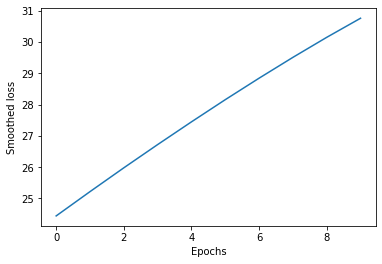

In [8]:
# Load names
data = open("rnn.txt", "r").read()

# Convert characters to lower case
data = data.lower()

# Construct vocabulary using unique characters, sort it in ascending order,
# then construct two dictionaries that maps character to index and index to
# characters.
chars = list(sorted(set(data)))
chars_to_idx = {ch:i for i, ch in enumerate(chars)}
idx_to_chars = {i:ch for ch, i in chars_to_idx.items()}

# Get the size of the data and vocab size
data_size = len(data)
vocab_size = len(chars_to_idx)
print(f"There are {data_size} characters and {vocab_size} unique characters.")

# Fitting the model
parameters, loss = model("/content/rnn.txt", chars_to_idx, idx_to_chars, 100, vocab_size, 10, 0.01)

# Plotting the loss
plt.plot(range(len(loss)), loss)
plt.xlabel("Epochs")
plt.ylabel("Smoothed loss");